# Neural Network

*With PyTorch*

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# custom file
from dataset import FaceEmotionsDataset
from transform import Rescale, RandomCrop, ToTensor, Normalize

### Load the data

To load the dataset I use a custom dataset class and custom transforms process our dataset.

In [2]:
data_transform = transforms.Compose([
    Rescale(68),
    RandomCrop(64),
    ToTensor()
])

emotions = ['neutral', 
            'happiness', 
            'surprise', 
            'sadness', 
            'anger', 
            'disgust',
            'fear',
            'contempt']

transformed_dataset = FaceEmotionsDataset(csv_file='csv/cleaned_data.csv',
                                          root_dir='img/',
                                          classes=emotions,
                                          transform=data_transform)

dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

0 torch.Size([4, 1, 64, 64]) torch.Size([4])


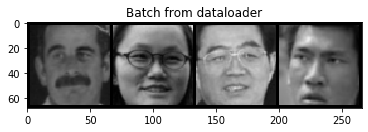

1 torch.Size([4, 1, 64, 64]) torch.Size([4])


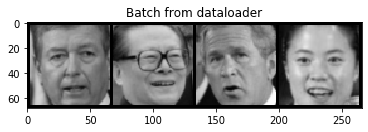

2 torch.Size([4, 1, 64, 64]) torch.Size([4])


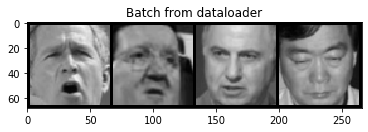

3 torch.Size([4, 1, 64, 64]) torch.Size([4])


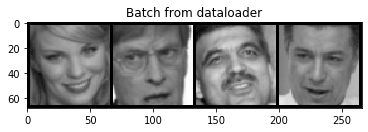

In [3]:
for i_batch, sample_batched in enumerate(dataloader):
    images_batch, emotions_batch = sample_batched['image'], sample_batched['emotion']
    print(i_batch, images_batch.size(),emotions_batch.size())

    # observe 4th batch and stop.
    
    plt.figure()
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    plt.title('Batch from dataloader')
    plt.show()
    
    if i_batch == 3:
        break
        